In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, MaxPool2D, Dropout, InputLayer, Input

import warnings
warnings.filterwarnings('ignore')

In [41]:
# Load the dataset from Tensorflow.
dataset, dataset_info = tfds.load("malaria", 
                                  with_info=True, 
                                  as_supervised=True, 
                                  data_dir = "C:/Users/Damilare/tensorflow_datasets",
                                  shuffle_files=True,
                                  download=False
                                #   split = ['train'] 
                                  )        # DatasetInfo - Info about dataset, num of examples and names of features.

In [42]:
# Correct the file path (use a raw string literal for clarity)
data_dir = r"C:/Users/Damilare/tensorflow_datasets/malaria/1.0.0/downloads/extracted/ZIP.data.lhnc.nlm.nih.gov_publ_Mala_cell_imagCpSVVrJBQVm1EAGSYJgFN2ZUxCZtjRh76bGSL61Dxmg.zip/cell_images"

# Define constants
batch_size = 32
img_height = 224
img_width = 224
train_ratio = 0.8
val_ratio = 0.2

# Pre-process the image (Resize and rescale)
def preprocess_image(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Load the dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Apply preprocessing
full_ds = full_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Calculate split sizes
total_size = tf.data.experimental.cardinality(full_ds).numpy()
print(f"Total dataset size: {total_size}")

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)

# Split the dataset
train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)


# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

Found 27558 files belonging to 2 classes.
Total dataset size: 862
Training dataset size: 689
Validation dataset size: 172


In [43]:
# Confirm image shape and data type
for image, label in train_ds.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Image data type: {image.dtype}")

Image shape: (32, 224, 224, 3)
Image data type: <dtype: 'float32'>


In [44]:
for image, _ in train_ds.take(1):       # Let's take a single batch

    # Let's calculate the statistics
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    
    print(f"Min value: {min_val.numpy()}")
    print(f"Max value: {max_val.numpy()}")


# Check if the values are within the expected range
if min_val >= 0 and max_val <= 1:
    print("The dataset is normalized between 0 and 1.")
elif min_val >= -1 and max_val <= 1:
    print("The dataset is normalized between -1 and 1.")
else:
    print("The dataset may not be properly normalized.")


Min value: 0.0
Max value: 0.929411768913269
The dataset is normalized between 0 and 1.


#### Dataset Visualization

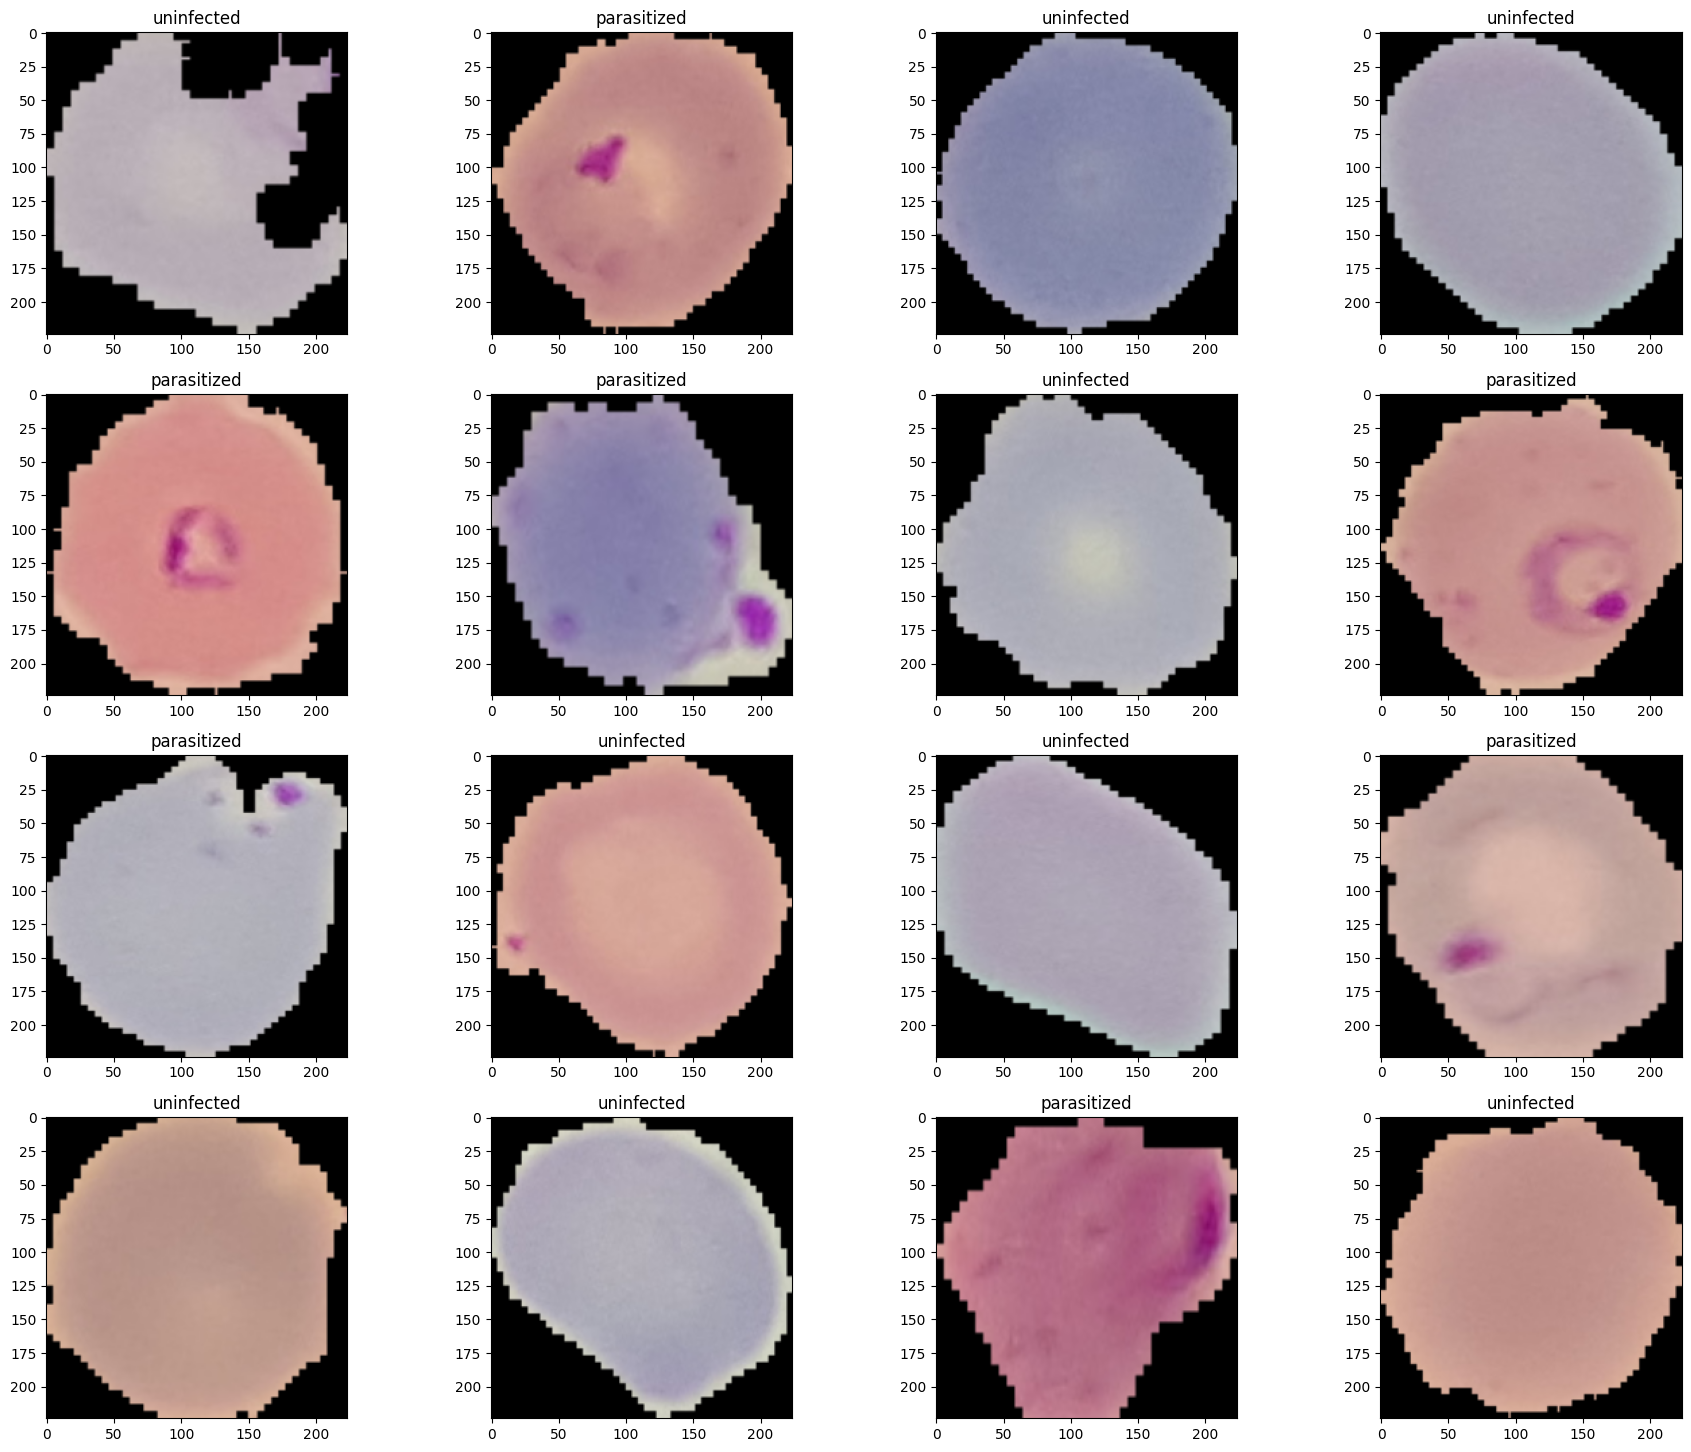

In [45]:
plt.figure(figsize=(22,18))
for i, (image, label) in enumerate(train_ds.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[0], cmap=None)
    plt.title(dataset_info.features['label'].int2str(label.numpy()[0]))

In [46]:
model = Sequential([
    # Input layer
    InputLayer(input_shape = (img_width, img_height, 3)),

    # 1st convolutional layer
    Conv2D(filters = 6, kernel_size = 3,  strides = (1, 1), padding = 'valid', activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),
    
    # 2nd convolutional layer
    Conv2D(filters = 16, kernel_size = 3,  strides = (1, 1), padding = 'valid', activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    # Flatten the output...
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),

    Dense(10, activation="relu"),
    BatchNormalization(),
    
    Dense(1, activation = "sigmoid")        # Binary classification  
])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_20 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_21 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [57]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate scheduler
def step_decay_schedule(initial_lr=0.01, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    return LearningRateScheduler(schedule)

# Compile the model with SGD optimizer and label smoothing
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [ ]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [59]:

# Define the learning rate scheduler callback
lr_scheduler = step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=10)

# Fit the model with the learning rate scheduler
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/20
689/689 [==============================] - 282s 408ms/step - loss: 0.5381 - accuracy: 0.9926 - val_loss: 0.5193 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 2/20
689/689 [==============================] - 399s 578ms/step - loss: 0.3257 - accuracy: 0.9907 - val_loss: 0.3720 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 3/20
689/689 [==============================] - 544s 790ms/step - loss: 0.2615 - accuracy: 0.9932 - val_loss: 0.3347 - val_accuracy: 0.9449 - lr: 0.0010
Epoch 4/20
689/689 [==============================] - 185s 268ms/step - loss: 0.2517 - accuracy: 0.9937 - val_loss: 0.3303 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 5/20
689/689 [==============================] - 161s 234ms/step - loss: 0.2475 - accuracy: 0.9939 - val_loss: 0.3299 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 6/20
689/689 [==============================] - 170s 246ms/step - loss: 0.2453 - accuracy: 0.9949 - val_loss: 0.3272 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 7/20
689/689 [==========================

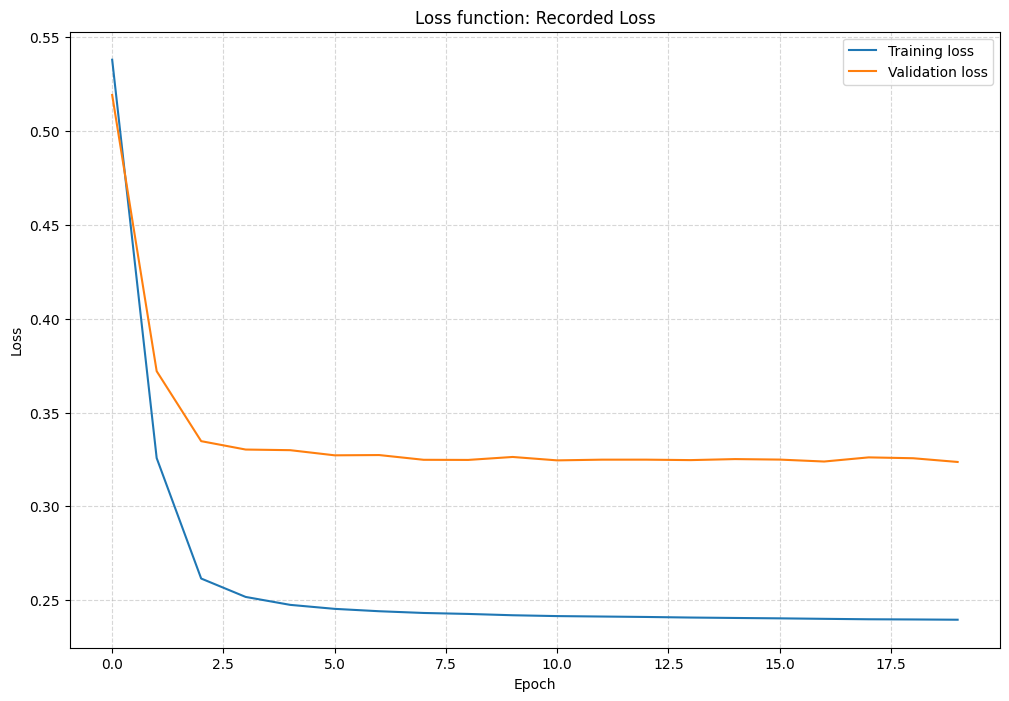

In [63]:
plt.figure(figsize=(12,8))
plt.grid(True, linestyle="--", alpha=0.5)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss function: Recorded Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training loss", "Validation loss"])
plt.show()

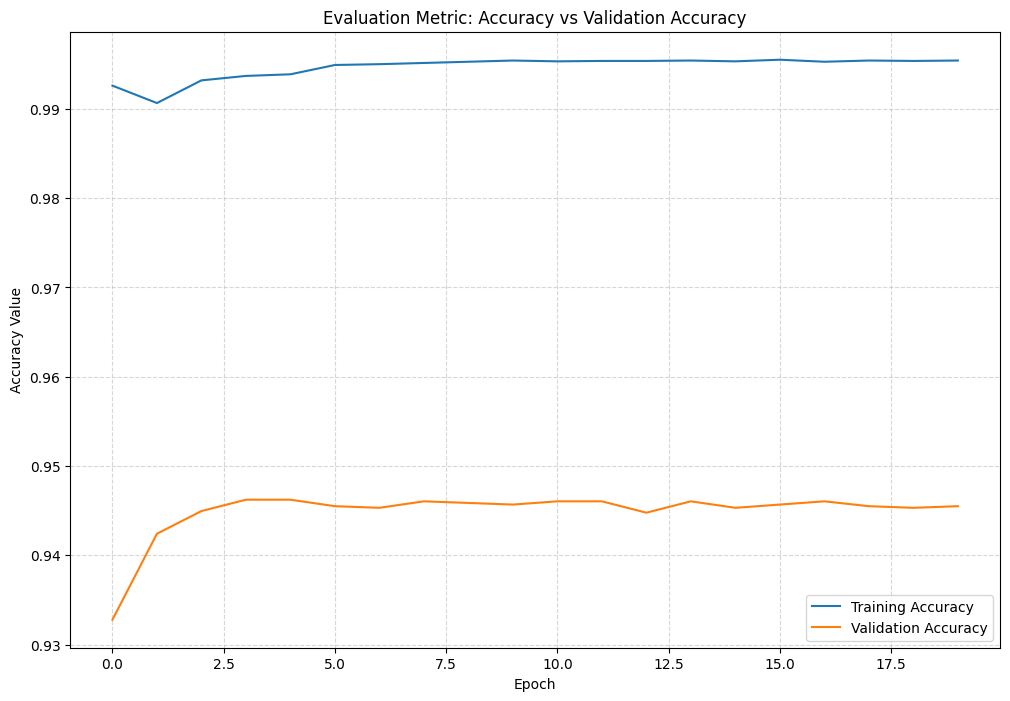

In [61]:
plt.figure(figsize=(12,8))
plt.grid(True, linestyle="--", alpha=0.5)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Evaluation Metric: Accuracy vs Validation Accuracy")
plt.ylabel("Accuracy Value")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

#### **Model Building**


In [62]:
# Save the built model...
model.save("new_model_new_update.hdf5")

In [64]:
# Let's evaluate the model with test-dataset
model.evaluate(test_ds)

87/87 [==============================] - 10s 115ms/step - loss: 0.3181 - accuracy: 0.9500


[0.31812429428100586, 0.9499637484550476]

In [65]:
# Let's make prediction:
def predict_result(x):
    if x < 0.5:
        result = "Parasitized"
    else:
        result = "Uninfected"
    return result

predict_result(model.predict(test_ds.take(1))[0][0])

1/1 [==============================] - 1s 679ms/step


'Parasitized'

16/16 [==============================] - 1s 58ms/step


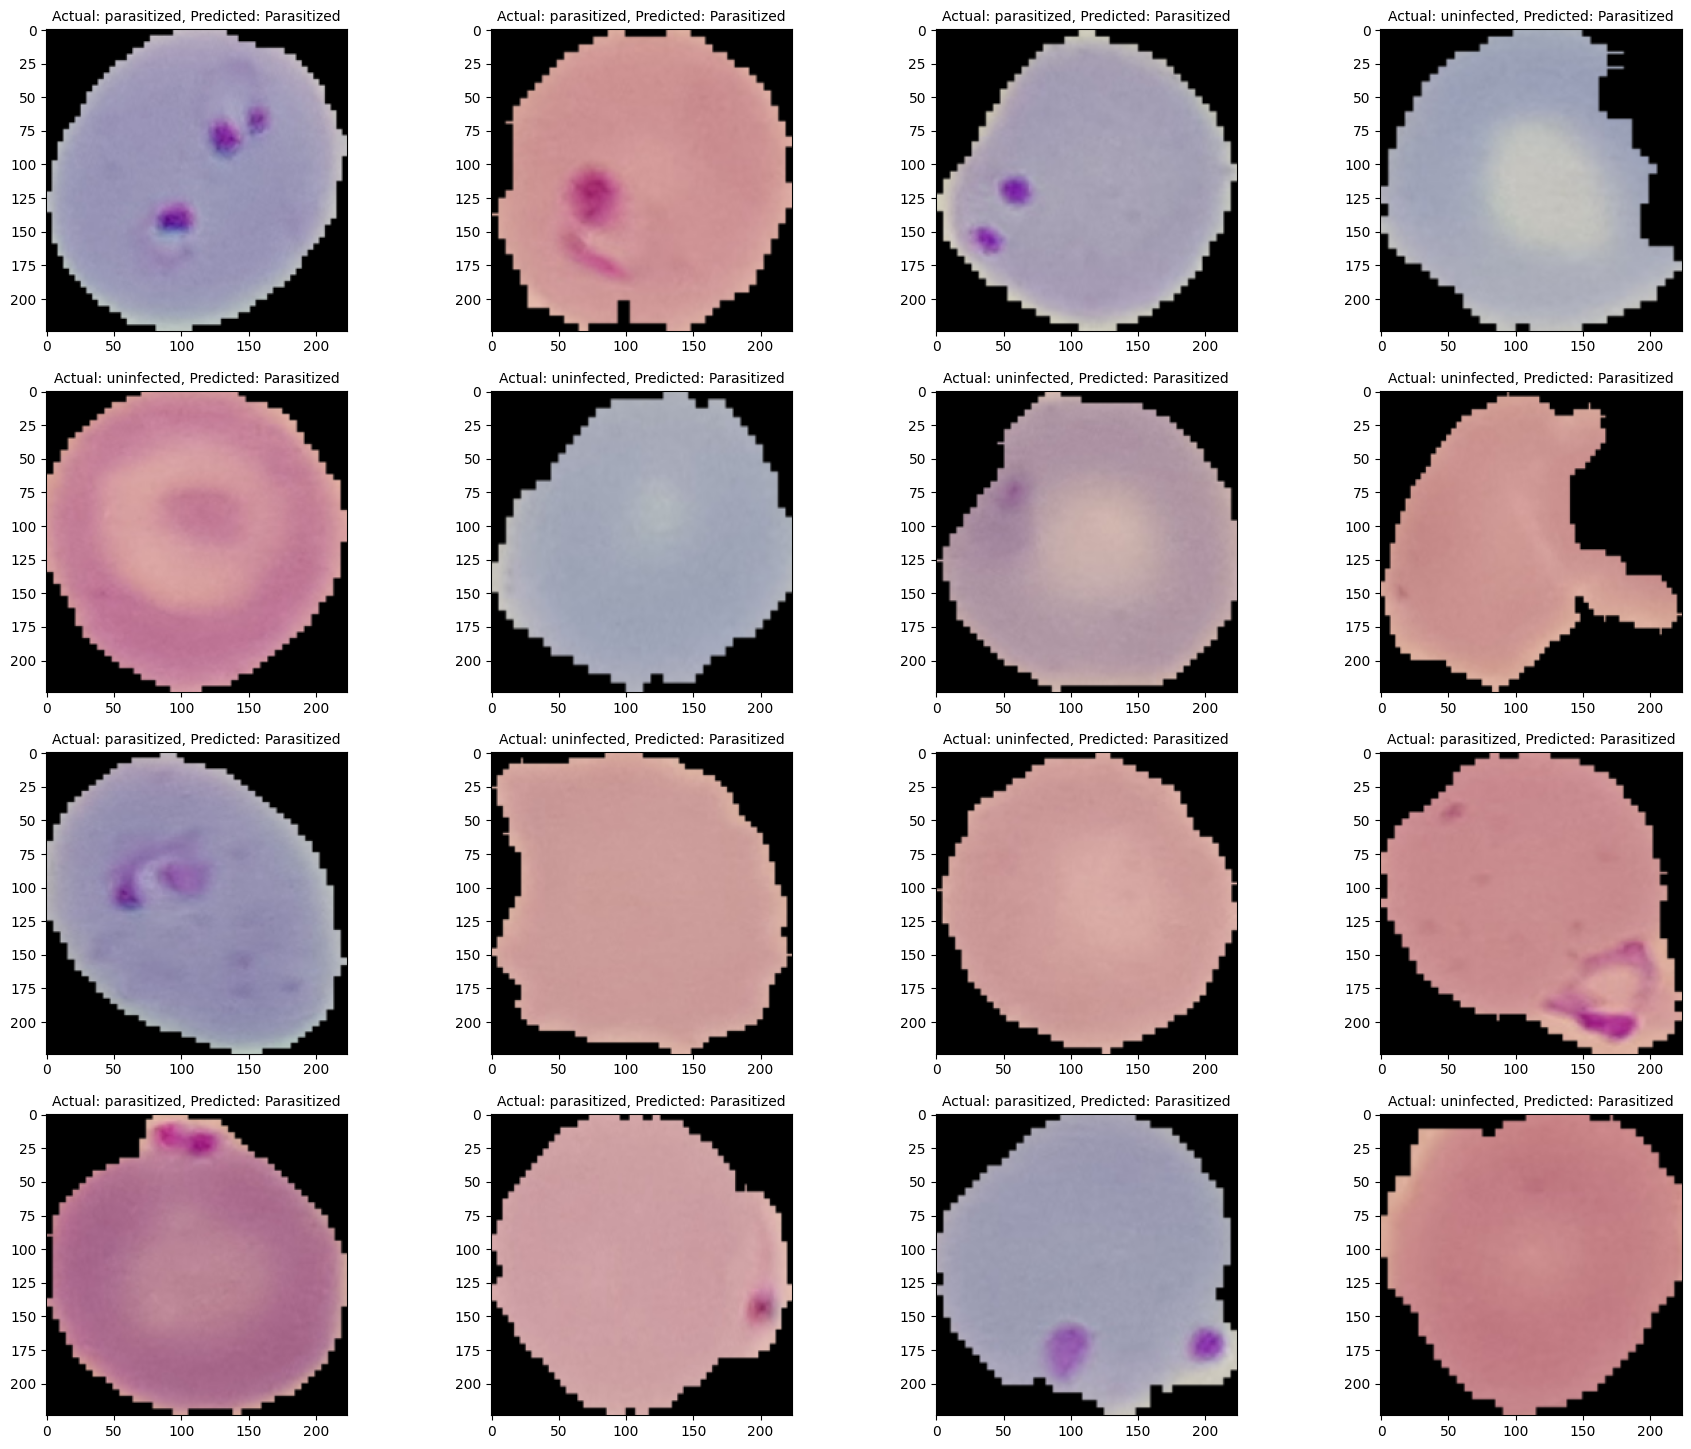

In [66]:
plt.figure(figsize=(22,18))
for i, (image, label) in enumerate(test_ds.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[0], cmap=None)
    plt.title(f"Actual: {dataset_info.features['label'].int2str(label.numpy()[0])}, Predicted: {predict_result(model.predict(test_ds.take(16))[0][0])}", fontsize=10)